In [4]:
#import PIL
import cv2
import tensorflow as tf
import numpy as np
import os
from matplotlib import pyplot as plt
%matplotlib inline

In [5]:
#PIL Import
#images = [PIL.Image.open('pics/'+x) for x in os.listdir('pics/')]
images = [compressable_image(cv2.imread('pics/'+x)) for x in os.listdir('pics/')]

In [20]:
#test.image
#img = cv2.imwrite('test_img.jpg', test.image)
#img = cv2.imdecode(mat,-1)
# The important part - Correct BGR to RGB channel
img = cv2.cvtColor(images[0].image, cv2.COLOR_BGR2RGB)
plt.imshow(img)

NameError: name 'images' is not defined

In [1]:
class compressable_image:
    def __init__(self, image):
        
        self.M = len(image)
        self.N = len(image[0])
        self.unrolled_image = self.unroll_image(image)
        self.image = []
        
    def unroll_image(self, original_image):
        new_image = []
        for i, row in enumerate(original_image):
            for j, pixel in enumerate(row):
                new_image.append(pixel)
        return new_image
    
    def k_means_compression(self, K=16, iteration_limit = 10):
        
        # ||x-mu||**2
        euclidean_distance = lambda x: np.inner(x,x)
        
        centroids = np.random.randint(255, size=(K, 3))
        last = np.zeros(self.M*self.N)
        assignments = np.zeros(self.M*self.N)
        changed = True
        iteration = 0
        while iteration < iteration_limit:
            for i, pixel in enumerate(self.unrolled_image):  
                assigned_k = -1
                closest = float('inf')
                for k, centroid in enumerate(centroids):
                    dist = euclidean_distance(pixel-centroids[k])
                    if dist < closest:
                        assigned_k, closest = k, dist
                assignments[i] = assigned_k
        
            if np.array_equal(last, assignments):
                break
            else:
                last = np.copy(assignments)
                assignments = np.zeros(self.M*self.N)
                
            for i, centroid in enumerate(centroids):
                points = [self.unrolled_image[x] for x in range(len(last)) if last[x] == i]
                if len(points) != 0:
                    new_centroid = np.sum(points, axis = 0)/len(points)
                    centroids[i] = new_centroid
            iteration += 1
            print(iteration)
        
        for pixel in range(len(self.unrolled_image)):
            self.unrolled_image[pixel] = centroids[int(last[pixel]),:]

        self.reroll_image()
        
    def reroll_image(self):
        
        self.image = []
        ind = 0
        for i in range(self.M):
            self.image.append([])
            for j in range(self.N):
                self.image[-1].append([])
                for d in range(3):
                    self.image[-1][-1].append(self.unrolled_image[ind][d])
                ind += 1
        self.image = np.asarray(self.image).astype(np.uint8)
    
        

In [98]:
def normalize(image):
    
    mean = np.mean(image,axis=0)
    stddev = np.std(image,axis=0)
    normalized = (image-mean)/stddev
    return normalized, mean, stddev

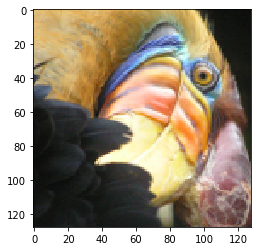

In [101]:
origimg = np.asarray(cv2.imread('pics/test.png'))
testimg = testimg.reshape((len(origimg), len(origimg[0])*3))
normalized, mean, stddev = normalize(testimg)
norm = normalized*stddev + mean
norm = norm.reshape((len(norm), len(norm[0])//3, 3)).astype(np.uint8)
img = cv2.cvtColor(norm, cv2.COLOR_BGR2RGB)
plt.imshow(img)

**Load Image and Normalize**

In [146]:
origimg = np.asarray(cv2.imread('pics/test.png'))
testimg = testimg.reshape((len(origimg), len(origimg[0])*3))
normalized, mean, stddev = normalize(testimg)

**Compute Covariance Matrix**

In [147]:
covariance = np.dot(normalized.T, normalized)/normalized.shape[0]
covariance.shape

(384, 384)

**Compute SVD Decomposition**

In [148]:
U, S, V = np.linalg.svd(covariance)
print(normalized.shape, U.shape)

(128, 384) (384, 384)


**Project Image and Unnormalize**

In [180]:
project = np.dot(normalized, U[:,:84])
project = np.dot(project,U[:,:84].T)
project = (project*stddev) + mean

**Reshape projection**

In [181]:
project = project.reshape((len(project),len(project[0])//3,3)).astype(np.uint8)
project.shape

(128, 128, 3)

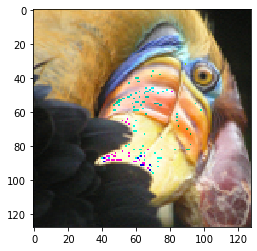

In [182]:
img = cv2.cvtColor(project, cv2.COLOR_BGR2RGB)
plt.imshow(img)

In [140]:
project = project.reshape((len(project),len(project[0])*3))

In [144]:
project = np.dot(project,U.T)

ValueError: shapes (128,128,3) and (384,384) not aligned: 3 (dim 2) != 384 (dim 0)

In [142]:
project = project.reshape((len(project),len(project[0])//3,3)).astype(np.uint8)

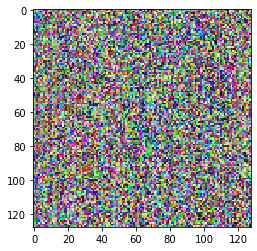

In [143]:
img = cv2.cvtColor(project, cv2.COLOR_BGR2RGB)
plt.imshow(img)